<a href="https://colab.research.google.com/github/alram6701/23-and-me-Raw-data-Analysis/blob/main/Cell_Comm_SIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scanpy
!pip install numpy
!pip install matplotlib

import scanpy as sc
import numpy as np
import matplotlib.pyplot as pl

In [ ]:
!pip install spatialdata
!pip install squidpy
import spatialdata
import squidpy

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text

In [ ]:
import anndata as ad
import pooch

In [ ]:
import pandas as pd
import gzip
from anndata import AnnData
from io import StringIO
filepath="/content/GSE70422_series_matrix.txt.gz"
def parse_geo_series_matrix(filepath):
    with gzip.open(filepath, "rt") as f:
        lines = f.readlines()

    # Extract sample metadata (dictionary of keys to list of values)
    sample_meta = {}
    data_started = False
    data_lines = []

    for line in lines:
        if line.startswith("!Sample_") and not line.startswith("!Sample_table_begin"):
            key, *values = line.strip().split("\t")
            key = key.replace("!Sample_", "")
            sample_meta[key] = values
        elif line.startswith("!series_matrix_table_begin"):
            data_started = True
        elif line.startswith("!series_matrix_table_end"):
            data_started = False
        elif data_started:
            data_lines.append(line)

    # Extract sample_geo_accession for indexing
    sample_geo_accession = sample_meta.get("geo_accession")
    if sample_geo_accession is None:
        raise ValueError("Sample geo_accession metadata not found.")

    # Create metadata DataFrame with GSM IDs as index
    obs = pd.DataFrame(sample_meta)
    obs.index = sample_geo_accession  # Set index to GSM IDs
    obs.index.name = "sample_id"

    # Load expression data (rows=probes, columns=samples (GSM IDs))
    data_str = "".join(data_lines)
    df = pd.read_csv(StringIO(data_str), sep="\t", index_col=0)

    # Transpose: rows = samples (GSM IDs), columns = probes/genes
    X = df.T
    X.index.name = "sample_id"

    # Clean whitespace/quotes if any (common in GEO files)
    X.index = X.index.str.strip().str.replace('"', '')
    obs.index = obs.index.str.strip().str.replace('"', '')

    # Align samples (intersection)
    common_ids = X.index.intersection(obs.index)

    # Filter to common samples
    X = X.loc[common_ids]
    obs = obs.loc[common_ids]

    # Create AnnData
    adata = AnnData(X=X, obs=obs)
    return adata

# Run it
adata = parse_geo_series_matrix(filepath)

# Print AnnData summary
print("\nAnnData summary:")
print(adata)



AnnData summary:
AnnData object with n_obs × n_vars = 55 × 29377
    obs: 'title', 'geo_accession', 'status', 'submission_date', 'last_update_date', 'type', 'channel_count', 'source_name_ch1', 'organism_ch1', 'characteristics_ch1', 'treatment_protocol_ch1', 'molecule_ch1', 'extract_protocol_ch1', 'label_ch1', 'label_protocol_ch1', 'taxid_ch1', 'hyb_protocol', 'scan_protocol', 'description', 'data_processing', 'platform_id', 'contact_name', 'contact_email', 'contact_phone', 'contact_institute', 'contact_address', 'contact_city', 'contact_zip/postal_code', 'contact_country', 'supplementary_file', 'data_row_count'


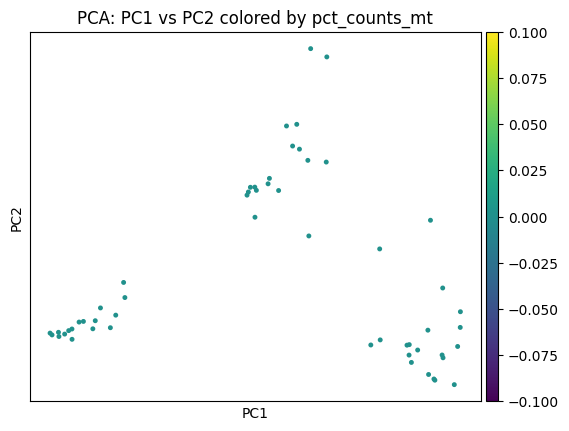

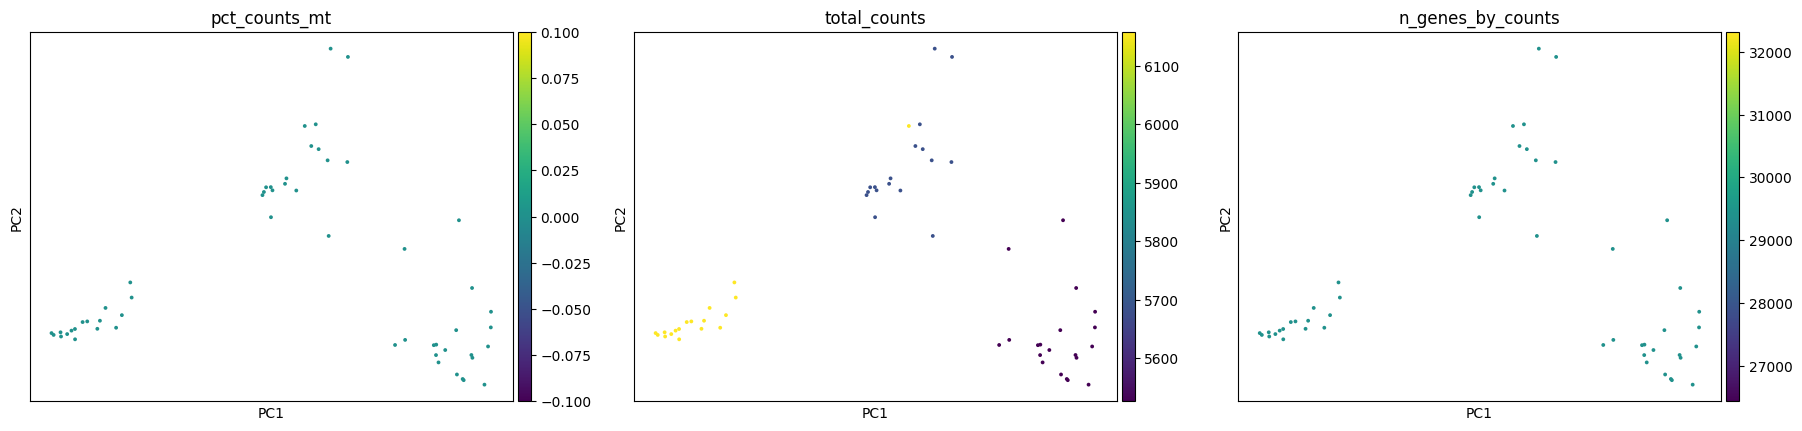

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

sc.pl.pca(
    adata,
    color="pct_counts_mt",
    components=["1,2"],  # PC1 vs PC2
    title="PCA: PC1 vs PC2 colored by pct_counts_mt",
    size=50

)

sc.pl.pca(
    adata,
    color=["pct_counts_mt", "total_counts", "n_genes_by_counts"],
    components=["1,2"],
    ncols=3,
    size=30
)


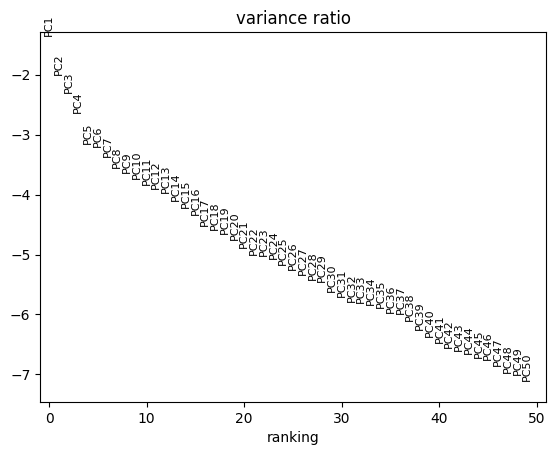

In [ ]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

KeyError: 'Could not find key sample in .var_names or .obs.columns.'

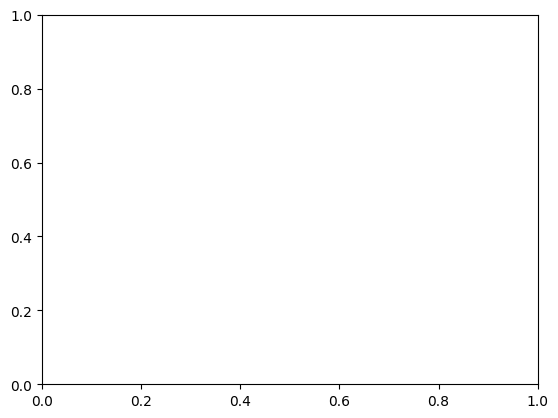

In [ ]:
import umap

sc.tl.umap(adata)

sc.pp.neighbors(adata)
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)


In [ ]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

KeyError: 'Could not find key leiden in .var_names or .obs.columns.'

<Figure size 2880x480 with 0 Axes>

TypeError: bad operand type for unary -: 'str'

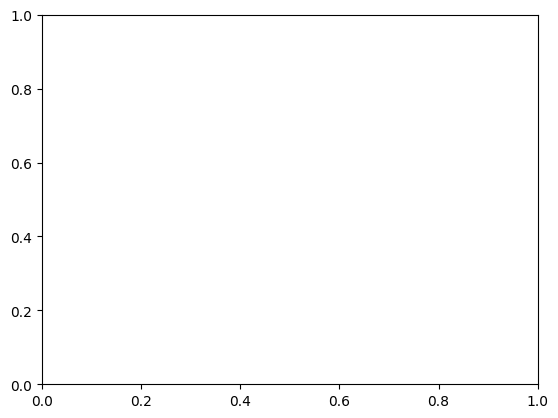

In [ ]:
import umap
import scanpy as sc # Ensure scanpy is imported if this cell is run independently

# Ensure Scanpy steps before UMAP are run if this is the first time this cell is run
# For example:
# sc.pp.neighbors(adata) # This is already in the cell, but just as a reminder

sc.tl.umap(adata)

# Use an existing column in adata.obs for coloring
# We'll use the 'title' column, which contains sample descriptions
# You could also use 'sample_id' or 'geo_accession'
if 'title' in adata.obs.columns:
    color_by = 'title'
elif 'sample_id' in adata.obs.columns:
     color_by = 'sample_id'
elif 'geo_accession' in adata.obs.columns:
     color_by = 'geo_accession'
else:
    # Fallback if none of the expected columns are found
    print("Warning: Neither 'title', 'sample_id', nor 'geo_accession' found in adata.obs. Plotting without color.")
    color_by = None # Plot without coloring if no suitable column exists

if color_by:
    sc.pl.umap(
        adata,
        color=color_by, # Changed 'sample' to the chosen existing column
        # Setting a smaller point size to prevent overlap
        size=2,
        title=f"UMAP colored by {color_by}" # Update title
    )
else:
     # Plot UMAP without color if no suitable column was found
    sc.pl.umap(
        adata,
        # Setting a smaller point size to prevent overlap
        size=2,
        title="UMAP (no suitable color column found)"
    )


AnnData summary:
AnnData object with n_obs × n_vars = 55 × 29377
    obs: 'title', 'geo_accession', 'status', 'submission_date', 'last_update_date', 'type', 'channel_count', 'source_name_ch1', 'organism_ch1', 'characteristics_ch1', 'treatment_protocol_ch1', 'molecule_ch1', 'extract_protocol_ch1', 'label_ch1', 'label_protocol_ch1', 'taxid_ch1', 'hyb_protocol', 'scan_protocol', 'description', 'data_processing', 'platform_id', 'contact_name', 'contact_email', 'contact_phone', 'contact_institute', 'contact_address', 'contact_city', 'contact_zip/postal_code', 'contact_country', 'supplementary_file', 'data_row_count'


<ipython-input-14-b6320a3c5d98>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group', y='expression', data=df_plot, errorbar="se", palette='pastel')


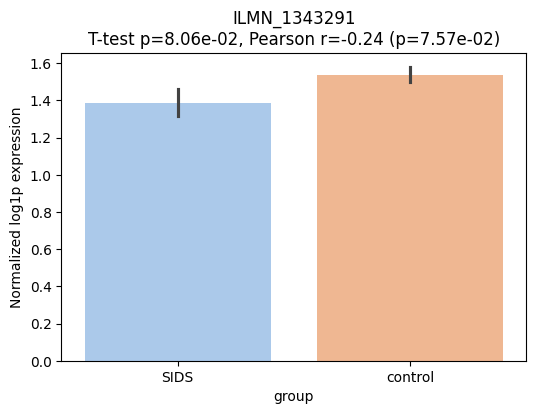

<ipython-input-14-b6320a3c5d98>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group', y='expression', data=df_plot, errorbar="se", palette='pastel')


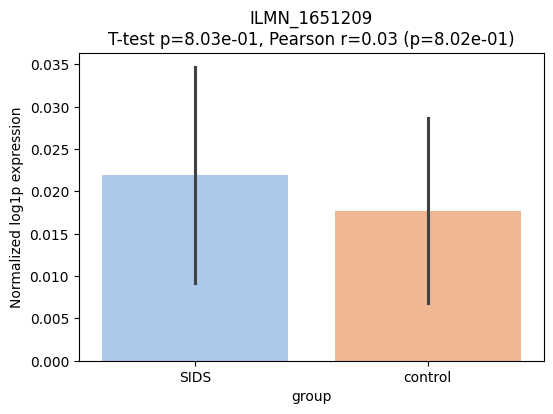

Gene ILMN_1234567 not found in dataset.


In [ ]:
import pandas as pd
import gzip
from anndata import AnnData
from io import StringIO
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr
filepath="/content/GSE70422_series_matrix.txt.gz"

def parse_geo_series_matrix(filepath):
    with gzip.open(filepath, "rt") as f:
        lines = f.readlines()

    # Extract sample metadata (dictionary of keys to list of values)
    sample_meta = {}
    data_started = False
    data_lines = []

    for line in lines:
        if line.startswith("!Sample_") and not line.startswith("!Sample_table_begin"):
            key, *values = line.strip().split("\t")
            key = key.replace("!Sample_", "")
            sample_meta[key] = values
        elif line.startswith("!series_matrix_table_begin"):
            data_started = True
        elif line.startswith("!series_matrix_table_end"):
            data_started = False
        elif data_started:
            data_lines.append(line)

    # Extract sample_geo_accession for indexing
    sample_geo_accession = sample_meta.get("geo_accession")
    if sample_geo_accession is None:
        raise ValueError("Sample geo_accession metadata not found.")

    # Create metadata DataFrame with GSM IDs as index
    obs = pd.DataFrame(sample_meta)
    obs.index = sample_geo_accession  # Set index to GSM IDs
    obs.index.name = "sample_id"

    # Load expression data (rows=probes, columns=samples (GSM IDs))
    data_str = "".join(data_lines)
    df = pd.read_csv(StringIO(data_str), sep="\t", index_col=0)

    # Transpose: rows = samples (GSM IDs), columns = probes/genes
    X = df.T
    X.index.name = "sample_id"

    # Clean whitespace/quotes if any (common in GEO files)
    X.index = X.index.str.strip().str.replace('"', '')
    obs.index = obs.index.str.strip().str.replace('"', '')

    # Align samples (intersection)
    common_ids = X.index.intersection(obs.index)

    # Filter to common samples
    X = X.loc[common_ids]
    obs = obs.loc[common_ids]

    # Create AnnData
    adata = AnnData(X=X, obs=obs)
    return adata

# Load your data
filepath = "/content/GSE70422_series_matrix.txt.gz"  # Replace with your filepath
adata = parse_geo_series_matrix(filepath)
print("\nAnnData summary:")
print(adata)

# ---- Add sample groups metadata ----
sample_names = list(adata.obs_names)  # Should be GSM IDs aligned with your data

# Insert your groups list matching sample_names order here:
groups = ['SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS',
          'SIDS','SIDS','control','control','control','control','control','control',
          'control','control','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS',
          'SIDS','SIDS','control','control','control','control','control',
          'control','control','control','control','control','SIDS',
          'SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','control',
          'control','control','control','control','control',
          'control',"control","control", "control"]

# Add group info to adata.obs
adata.obs['group'] = groups

# ---- Normalize expression with Scanpy ----
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize counts per sample to 10,000
sc.pp.log1p(adata)  # Log-transform (log(x+1))

# ---- Extract normalized data as DataFrame ----
df_norm = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

# ---- Genes to compare ----
genes_of_interest = ['ILMN_1343291', 'ILMN_1651209', 'ILMN_1234567']  # replace with your gene IDs

# ---- Plot and stats ----
for gene in genes_of_interest:
    if gene not in df_norm.columns:
        print(f"Gene {gene} not found in dataset.")
        continue

    gene_expr = df_norm[gene]
    df_plot = pd.DataFrame({'expression': gene_expr, 'group': adata.obs['group']})

    # Barplot
    plt.figure(figsize=(6,4))
    sns.barplot(x='group', y='expression', data=df_plot, errorbar="se", palette='pastel')

    # Stats: t-test SIDS vs control
    sids_vals = df_plot[df_plot['group'] == 'SIDS']['expression']
    ctrl_vals = df_plot[df_plot['group'] == 'control']['expression']
    t_stat, p_val = ttest_ind(sids_vals, ctrl_vals, equal_var=False)

    # Correlation group vs expression (binary encoding)
    group_bin = df_plot['group'].apply(lambda x: 1 if x == 'SIDS' else 0)
    corr, corr_p = pearsonr(group_bin, df_plot['expression'])

    plt.title(f"{gene}\nT-test p={p_val:.2e}, Pearson r={corr:.2f} (p={corr_p:.2e})")
    plt.ylabel("Normalized log1p expression")
    plt.show()


In [ ]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

In [ ]:
import numpy as np

# Convert to float if not already
adata.X = adata.X.astype(np.float64)

# Replace NaNs with 0
adata.X[np.isnan(adata.X)] = 0

# Replace infs with large finite value
finite_max = np.max(adata.X[np.isfinite(adata.X)])
adata.X[np.isinf(adata.X)] = finite_max

# Remove genes (columns) with zero variance
nonzero_var_genes = np.var(adata.X, axis=0) > 0
adata = adata[:, nonzero_var_genes]
print(np.isnan(adata.X).sum(), "NaNs")
print(np.isinf(adata.X).sum(), "Infs")
print(np.var(adata.X, axis=0))  # Check gene variance


0 NaNs
0 Infs
[2.46851558 2.10276828 1.80329938 ... 3.3485319  1.42839432 1.71920247]


In [ ]:
# Drop genes with missing names (NaN or empty strings)
valid_genes = ~adata.var_names.isna() & (adata.var_names != "")
adata = adata[:, valid_genes]

# Also ensure gene names are unique
adata.var_names_make_unique()
import numpy as np
import pandas as pd

# 1. Ensure X is a numeric NumPy array or sparse matrix
adata.X = adata.X.astype(np.float64)

# 2. Remove any NaNs or infs
adata.X[np.isnan(adata.X)] = 0
adata.X[np.isinf(adata.X)] = 0

# 3. Drop genes (columns) with zero variance
gene_variance = np.var(adata.X, axis=0)
nonzero_var_genes = gene_variance > 0
adata = adata[:, nonzero_var_genes]

# 4. Make sure gene names are valid
adata.var_names = adata.var_names.astype(str)
adata.var_names = adata.var_names.str.strip()
adata.var_names_make_unique()


In [ ]:
!pip3 install igraph
!pip3 install leidenalg
!pip3 install python-igraph
import igraph as ig
import scanpy as sc
# Run preprocessing steps before clustering
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)

# Run Leiden clustering at resolution 0.2
sc.tl.leiden(adata, resolution=0.2, key_added="leiden_res_0.2")  # creates adata.obs["leiden_res_0.2"]
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.2", standard_scale="var")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:243: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:387: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


ValueError: Bin edges must be unique: Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [ ]:
!pip3 install igraph
!pip3 install leidenalg
!pip3 install python-igraph
import igraph as ig
import scanpy as sc
import numpy as np # Ensure numpy is imported

# Run preprocessing steps before clustering
# It seems you ran normalize_total and log1p earlier, but it's good practice
# to include them again here before HVG selection if this cell is run independently
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# --- Debugging: Check data state before HVG ---
# Calculate gene means
gene_means = np.mean(adata.X, axis=0)
print(f"Shape of gene means: {gene_means.shape}")
print(f"First 10 gene means: {gene_means[:10]}")
print(f"Min gene mean: {np.min(gene_means)}")
print(f"Max gene mean: {np.max(gene_means)}")
print(f"Any NaN in gene means? {np.isnan(gene_means).any()}")
print(f"Any Inf in gene means? {np.isinf(gene_means).any()}")

# Check if all gene means are the same
if np.all(gene_means == gene_means[0]):
    print("Warning: All gene means are identical. Highly variable gene selection may fail.")
    # You might skip HVG or try a different method if this happens
    # For now, we'll proceed to see if Scanpy handles it better now
    # after ensuring no NaNs/Infs in .X and checking means.

# --- End Debugging ---

# Identify highly variable genes
# Using default parameters (n_top_genes=None, flavor='seurat') might be more robust
# initially if you suspect issues with the data range/distribution for binning.
# However, let's keep n_top_genes=2000 as in your original code, but ensure data is clean.
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat') # Added flavor for potentially more robust method

# Subset to highly variable genes
adata = adata[:, adata.var.highly_variable].copy() # Use .copy() to avoid view warnings later

# Scale the data (usually done after HVG selection and subsetting)
# Scaling is sensitive to extreme values and lack of variance, ensure data is clean before this.
# Add clipping before scaling as a precaution against potential residual large values
adata.X = np.clip(adata.X, a_min=None, a_max=100) # Clip values before scaling
sc.pp.scale(adata, max_value=10)

# PCA dimensionality reduction
sc.tl.pca(adata)

# Build neighborhood graph
sc.pp.neighbors(adata)

# Run Leiden clustering at resolution 0.2
# Use the original key_added name to avoid issues in subsequent plots
sc.tl.leiden(adata, resolution=0.2, key_added="leiden") # Renamed key_added to "leiden" for typical workflow

# Plot dotplot using the new leiden clustering result
sc.pl.dotplot(adata, marker_genes, groupby="leiden", standard_scale="var")

Shape of gene means: (2000,)
First 10 gene means: [nan nan nan nan nan nan nan nan nan nan]
Min gene mean: nan
Max gene mean: nan
Any NaN in gene means? True
Any Inf in gene means? False


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:243: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


ValueError: Bin edges must be unique: Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [ ]:
import numpy as np

# Convert to float64 and replace NaNs with 0 (or use mean imputation)
adata.X = adata.X.astype(np.float64)
adata.X = np.nan_to_num(adata.X, nan=0.0)  # Option 1: replace NaNs with 0
# OR use mean imputation (better for microarray data)
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy="mean")
# adata.X = imputer.fit_transform(adata.X)


In [ ]:
import scanpy as sc

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

# Keep only highly variable genes
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:414: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
import numpy as np
import pandas as pd

print("Shape:", adata.shape)
print("Any NaNs:", np.isnan(adata.X).any())
print("All values zero?", np.all(adata.X == 0))
print("Per-gene variance:", np.var(adata.X, axis=0)[:10])
print("Max value:", np.nanmax(adata.X))
print("Min value:", np.nanmin(adata.X))


Shape: (55, 2000)
Any NaNs: False
All values zero? True
Per-gene variance: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max value: 0.0
Min value: 0.0


In [ ]:
adata = parse_geo_series_matrix(filepath)
print("\nAnnData summary:")
print(adata)
print(adata.obs.head())




AnnData summary:
AnnData object with n_obs × n_vars = 55 × 29377
    obs: 'title', 'geo_accession', 'status', 'submission_date', 'last_update_date', 'type', 'channel_count', 'source_name_ch1', 'organism_ch1', 'characteristics_ch1', 'treatment_protocol_ch1', 'molecule_ch1', 'extract_protocol_ch1', 'label_ch1', 'label_protocol_ch1', 'taxid_ch1', 'hyb_protocol', 'scan_protocol', 'description', 'data_processing', 'platform_id', 'contact_name', 'contact_email', 'contact_phone', 'contact_institute', 'contact_address', 'contact_city', 'contact_zip/postal_code', 'contact_country', 'supplementary_file', 'data_row_count'
                title geo_accession                   status submission_date  \
sample_id                                                                      
GSM1728971  "403_11B"  "GSM1728971"  "Public on Mar 01 2016"   "Jun 30 2015"   
GSM1728972  "617_12B"  "GSM1728972"  "Public on Mar 01 2016"   "Jun 30 2015"   
GSM1728973  "182_09B"  "GSM1728973"  "Public on Mar 01 2016"

In [ ]:
import scanpy as sc
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


In [ ]:
import numpy as np

# Add a small constant to avoid log(0)
adata.X = np.log1p(adata.X)
from sklearn.preprocessing import quantile_transform

# Quantile normalize across samples (rows)
adata.X = quantile_transform(adata.X, axis=0, copy=True)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (55). n_quantiles is set to n_samples.
  warnings.warn(


In [ ]:
import scanpy as sc

# Normalize total counts to 1 million per sample
sc.pp.normalize_total(adata, target_sum=1e6)

# Log-transform normalized data
sc.pp.log1p(adata)

print(adata.X[:5, :5])  # check first few entries


[[5.50261916 1.0300409  3.33576875 4.89562697 4.27575306]
 [5.37622008 0.89701714 4.26334196 5.00894908 2.96902459]
 [5.49197875 0.51605045 1.83517769 4.98192333 3.99538396]
 [5.42565008 0.32944484 1.87977235 4.97725028 4.02897244]
 [4.90488766 0.25366841 5.29923458 4.62179136 2.10643685]]


In [ ]:
genes_of_interest = ["ILMN_1681526", "ILMN_1742548", "ILMN_1690420"]  # Replace with your actual gene IDs
adata.var_names = adata.var_names if hasattr(adata, 'var_names') else adata.var.index
# Check if genes_of_interest are in var_names
print([g for g in genes_of_interest if g not in adata.var_names])


[]


In [ ]:
import pandas as pd

# Slice the matrix to only those genes
expr_subset = adata[:, genes_of_interest].X  # This will be (55 samples × 3 genes)

# Convert to DataFrame for easier plotting, use sample IDs as index, gene IDs as columns
df_expr = pd.DataFrame(expr_subset, index=adata.obs_names, columns=genes_of_interest)


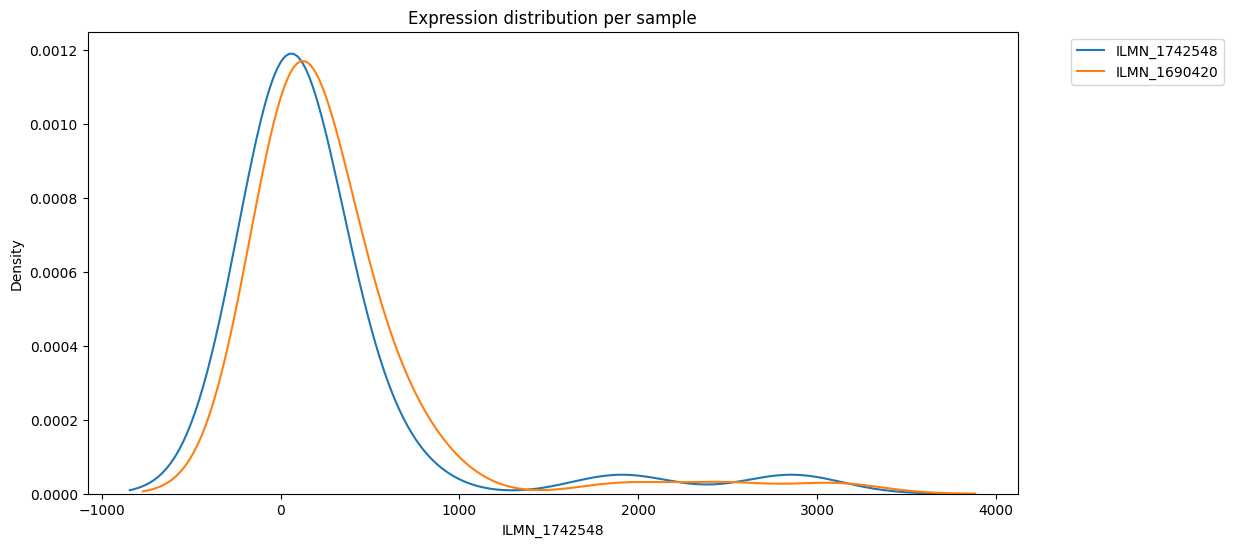

KeyError: "['gene_id'] not found in axis"

<Figure size 1200x600 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms or density plots per sample
plt.figure(figsize=(12,6))
for sample in df_expr.columns[1:]:  # exclude 'gene_id' or first col if present
    sns.kdeplot(df_expr[sample], label=sample)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Expression distribution per sample')
plt.show()

# Or boxplots per sample
plt.figure(figsize=(12,6))
sns.boxplot(data=df_expr.drop(columns=['gene_id']))  # or your gene id col
plt.xticks(rotation=90)
plt.title('Boxplot of expression per sample')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of gene expression across samples
plt.figure(figsize=(10,8))
sns.heatmap(df_expr.T, cmap="viridis", cbar_kws={'label': 'Expression'})
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.title("Expression of selected genes across samples")
plt.show()


NameError: name 'df_expr' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr

# 1. Prepare expression data (example, replace with your loading step)
# Suppose df_expr_raw is a DataFrame with gene IDs in index and samples as columns (GSM IDs)
# For example:
# df_expr_raw = pd.read_csv('your_expression_data.csv', index_col=0)  # or load however you have it

# --- Dummy example structure ---
# df_expr_raw = pd.DataFrame({
#    "GSM1728971": [...],
#    "GSM1728972": [...],
#    ...
# }, index=[gene_ids])

# 2. Create AnnData from raw counts (genes x samples)
adata = sc.AnnData(df_expr_raw.T)  # transpose so samples = obs, genes = var

# 3. Add sample group metadata based on GSM IDs
sample_names = ["GSM1728971", "GSM1728972", "GSM1728973", "GSM1728974", "GSM1728975", #...
                # add full list here
               ]

groups = ['SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS',
          'SIDS','SIDS','control','control','control','control','control','control',
          'control','control','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS',
          'SIDS','SIDS','control','control','control','control','control',
          'control','control','control','control','control','SIDS',
          'SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','control',
          'control','control','control','control','control',
          'control',"control","control", "control"]

# Build metadata DataFrame
metadata = pd.DataFrame({'group': groups}, index=sample_names)

# Map metadata to adata.obs
adata.obs['group'] = metadata.loc[adata.obs_names, 'group']

# 4. Normalize the data with Scanpy
sc.pp.normalize_total(adata, target_sum=1e4)  # normalize counts per sample to 10,000
sc.pp.log1p(adata)  # log-transform: log(x+1)

# 5. Extract normalized expression matrix into a DataFrame for easier handling
df_norm = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

# 6. Select genes of interest (replace with your gene IDs)
genes_of_interest = ['ILMN_1343291', 'ILMN_1651209', 'ILMN_1234567']  # example IDs

# 7. Prepare data for plotting and stats
for gene in genes_of_interest:
    # Extract expression for this gene
    gene_expr = df_norm[gene]

    # Create DataFrame with expression and group info
    df_plot = pd.DataFrame({
        'expression': gene_expr,
        'group': adata.obs['group']
    })

    # Calculate mean and SEM per group for plotting
    means = df_plot.groupby('group')['expression'].mean()
    sems = df_plot.groupby('group')['expression'].sem()

    # Perform t-test between groups
    group1_expr = df_plot[df_plot['group'] == 'SIDS']['expression']
    group2_expr = df_plot[df_plot['group'] == 'control']['expression']
    t_stat, p_val = ttest_ind(group1_expr, group2_expr, equal_var=False)

    # Correlation (optional, example between expression and a binary group variable)
    group_binary = df_plot['group'].apply(lambda x: 1 if x == 'SIDS' else 0)
    corr, corr_p = pearsonr(group_binary, df_plot['expression'])

    # Plot
    plt.figure(figsize=(6,4))
    sns.barplot(x='group', y='expression', data=df_plot, ci='sem', palette='pastel')
    plt.title(f'Gene: {gene}\nT-test p={p_val:.3e}, Pearson r={corr:.2f} (p={corr_p:.3e})')
    plt.ylabel('Normalized expression (log1p)')
    plt.show()


NameError: name 'df_expr_raw' is not defined

<ipython-input-23-dcab814a1144>:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_expr, x='group', y=gene, ci='sd', palette='pastel')
<ipython-input-23-dcab814a1144>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_expr, x='group', y=gene, ci='sd', palette='pastel')
<ipython-input-23-dcab814a1144>:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_expr, x='group', y=gene, ci='sd', palette='pastel')
<ipython-input-23-dcab814a1144>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_expr, x='group', y=gene, ci='sd', palette='pastel')
<ipython

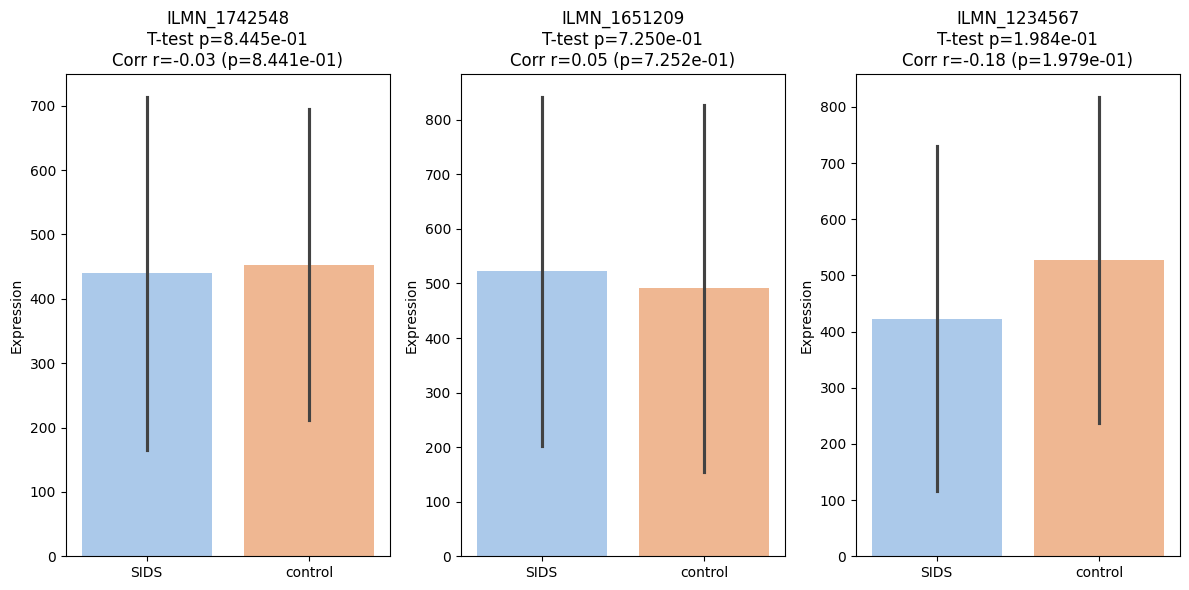

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr

# Your original data (replace this with your real df_expr)
sample_names = ["GSM1728971","GSM1728972","GSM1728973", "GSM1728974",
                "GSM1728975", "GSM1728976","GSM1728977", "GSM1728978","GSM1728979",
                "GSM1728980","GSM1728981","GSM1728982",
                "GSM1728983","GSM1728984","GSM1728985","GSM1728986",
                "GSM1728988", "GSM1728989", "GSM1728990", "GSM1728991","GSM1728992","GSM1728993",
                "GSM1728994","GSM1728995","GSM1728996",
                "GSM1728997","GSM1728998","GSM1728999","GSM1729000","GSM1729001",
                "GSM1729002","GSM1729003",
                "GSM1729004", "GSM1729005", "GSM1729006","GSM1729007",
                "GSM1729008", "GSM1729009", "GSM1729010", "GSM1729011", "GSM1729012",
                "GSM1729013", "GSM1729014", "GSM1729015", "GSM1729017",
                "GSM1729018", "GSM1729019",
                "GSM1729020","GSM1729021", "GSM1729022",
                "GSM1729023", "GSM1729024","GSM1729026", "GSM1729027",
                "GSM1729028"]

groups = ['SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS',
          'SIDS','SIDS','control','control','control','control','control','control',
          'control','control','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS',
          'SIDS','SIDS','control','control','control','control','control',
          'control','control','control','control','control','SIDS',
          'SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','control',
          'control','control','control','control','control',
          'control',"control","control", "control"]

sample_to_group = dict(zip(sample_names, groups))

genes_of_interest = ['ILMN_1742548', 'ILMN_1651209', 'ILMN_1234567']

# Dummy data simulating expression for demonstration (replace with your real data)
np.random.seed(42)
df_expr = pd.DataFrame(np.random.rand(len(sample_names), len(genes_of_interest)) * 1000,
                       index=sample_names,
                       columns=genes_of_interest)

df_expr['group'] = df_expr.index.map(sample_to_group)

# Encode group as numeric for correlation: control=0, SIDS=1
df_expr['group_num'] = df_expr['group'].map({'control': 0, 'SIDS': 1})

# Prepare plot
plt.figure(figsize=(12, 6))

for i, gene in enumerate(genes_of_interest):
    plt.subplot(1, len(genes_of_interest), i+1)

    # Barplot with mean and sem
    sns.barplot(data=df_expr, x='group', y=gene, ci='sd', palette='pastel')

    # T-test between groups
    group1 = df_expr[df_expr['group'] == 'control'][gene]
    group2 = df_expr[df_expr['group'] == 'SIDS'][gene]
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)

    # Pearson correlation with group_num
    corr_coef, corr_p = pearsonr(df_expr['group_num'], df_expr[gene])

    # Annotate p-values and correlation on plot
    plt.title(f"{gene}\nT-test p={p_val:.3e}\nCorr r={corr_coef:.2f} (p={corr_p:.3e})")
    plt.xlabel('')
    plt.ylabel('Expression')

plt.tight_layout()
plt.show()


In [ ]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)


NameError: name 'sc' is not defined

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.8 MB/s eta 0:00:00
Data stats after clipping: max=15.0, min=2.782962483, any NaN? False, any inf? False


<ipython-input-41-e05fd0ef68d8>:46: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


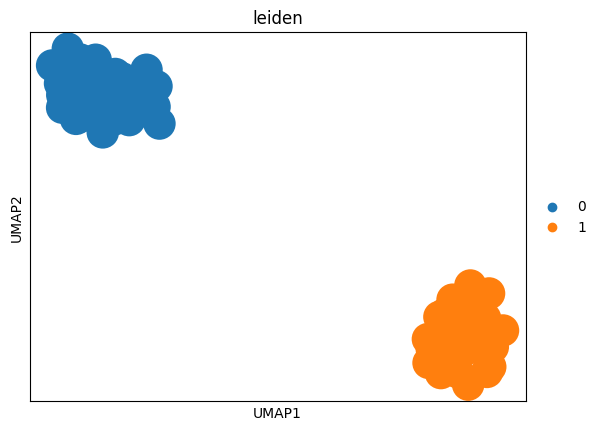

No 'condition' column found in adata.obs for differential expression.


In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
!pip install igraph
!pip3 install leidenalg

# 1. Load GEO matrix, skipping metadata lines starting with '!'
df = pd.read_csv("/content/GSE70422_series_matrix.txt.gz", sep='\t', comment='!', index_col=0)

# 2. Convert all data to numeric, coerce errors to NaN
df = df.apply(pd.to_numeric, errors='coerce')

# 3. Drop rows with any NaN (non-numeric or missing data)
df = df.dropna()

# 4. Transpose so samples are rows, genes are columns
df = df.T

# 5. Create AnnData object
adata = sc.AnnData(df)

# 6. Replace any NaN or inf in adata.X with 0
adata.X[np.isnan(adata.X)] = 0
adata.X[np.isinf(adata.X)] = 0

# 7. Clip large values to max 15 to avoid overflow in downstream functions
adata.X = np.clip(adata.X, a_min=None, a_max=15)

print(f"Data stats after clipping: max={adata.X.max()}, min={adata.X.min()}, any NaN? {np.isnan(adata.X).any()}, any inf? {np.isinf(adata.X).any()}")

# 8. Identify highly variable genes using Seurat flavor
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)
adata = adata[:, adata.var.highly_variable].copy()

# 9. Scale data (clip max to 10 for scaling step)
sc.pp.scale(adata, max_value=10)

# 10. PCA dimensionality reduction
sc.tl.pca(adata, svd_solver='arpack')

# 11. Build neighborhood graph and compute UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# 12. Clustering with Leiden algorithm
sc.tl.leiden(adata, resolution=0.5)

# 13. Visualize UMAP with clusters and conditions (adjust 'condition' column if present)
if 'condition' in adata.obs.columns:
    sc.pl.umap(adata, color=['leiden', 'condition'])
else:
    sc.pl.umap(adata, color='leiden')

# 14. Differential expression testing between groups in 'condition' (modify if needed)
if 'condition' in adata.obs.columns:
    sc.tl.rank_genes_groups(adata, groupby='condition', method='wilcoxon')
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
    # Export results
    deg_results = sc.get.rank_genes_groups_df(adata, group=None)
    deg_results.to_csv('differential_expression_results.csv', index=False)
else:
    print("No 'condition' column found in adata.obs for differential expression.")



In [ ]:
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)
adata = adata[:, adata.var.highly_variable].copy()
# Check for numeric-only rows
df_numeric = df.applymap(np.isreal).all(axis=1)
df_clean = df[df_numeric]
# Read only the numeric part of the GEO matrix
df = pd.read_csv("/content/GSE70422_series_matrix.txt.gz", sep='\t', comment='!', index_col=0)

# Remove rows with any non-numeric values
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# Transpose
adata = sc.AnnData(df.T)


ValueError: cannot specify integer `bins` when input data contains infinity

In [ ]:
import scanpy as sc
import pandas as pd

# Step 1: Add group labels to .obs (if not already done)
# Use your mapping from earlier
sample_to_group = dict(zip(sample_names, groups))
adata.obs['group'] = adata.obs.index.map(sample_to_group)

# Step 2: Run normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Step 3: Differential expression testing
sc.tl.rank_genes_groups(adata, groupby='group', reference='control',
                        method='t-test')

# Step 4: Extract results
degs = sc.get.rank_genes_groups_df(adata, group='SIDS')

# Optional: Filter by significance (e.g. adjusted p-value < 0.05 and logFC threshold)
sig_degs = degs[(degs['pvals_adj'] < 0.05) &
 (degs['logfoldchanges'].abs() > 1)]

# Display top differentially expressed genes
print(sig_degs.head(20))

# Save to CSV
sig_degs.to_csv("SIDS_vs_control_DEGs.csv", index=False)


Empty DataFrame
Columns: [names, scores, logfoldchanges, pvals, pvals_adj]
Index: []


In [ ]:
# Basic filtering (optional if already cleaned)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Calculate mitochondrial content if needed
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


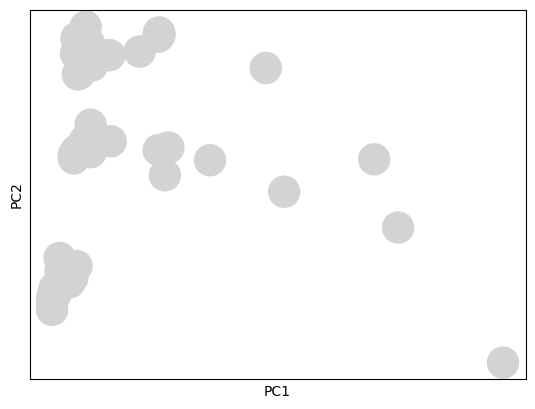

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)


In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


KeyError: 'leiden'

In [ ]:
import numpy as np

print(np.max(adata.X))
print(np.min(adata.X))


7.278511056666148
-6.56922252541931


In [ ]:

sample_names = ["GSM1728971","GSM1728972","GSM1728973", "GSM1728974",
                "GSM1728975", "GSM1728976","GSM1728977", "GSM1728978","GSM1728979",
                "GSM1728980","GSM1728981","GSM1728982",
                "GSM1728983","GSM1728984","GSM1728985","GSM1728986",
                "GSM1728988", "GSM1728989", "GSM1728990", "GSM1728991","GSM1728992","GSM1728993",
                "GSM1728994","GSM1728995","GSM1728996",
                "GSM1728997","GSM1728998","GSM1728999","GSM1729000","GSM1729001",
                "GSM1729002","GSM1729003",
                "GSM1729004", "GSM1729005", "GSM1729006","GSM1729007",
                "GSM1729008", "GSM1729009", "GSM1729010", "GSM1729011", "GSM1729012",
                "GSM1729013", "GSM1729014", "GSM1729015", "GSM1729017",
                "GSM1729018", "GSM1729019",
                "GSM1729020","GSM1729021", "GSM1729022",
                "GSM1729023", "GSM1729024","GSM1729026", "GSM1729027",
                "GSM1729028"]

groups=['SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS',
        'SIDS','SIDS','control','control','control','control','control','control',
        'control','control','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS',
        'SIDS','SIDS','control','control','control','control','control',
        'control','control','control','control','control','SIDS',
        'SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','control',
        'control','control','control','control','control',
        'control',"control","control", "control"]

condition
control    11
SIDS       10
Name: count, dtype: int64
organ
Liver    21
Name: count, dtype: int64


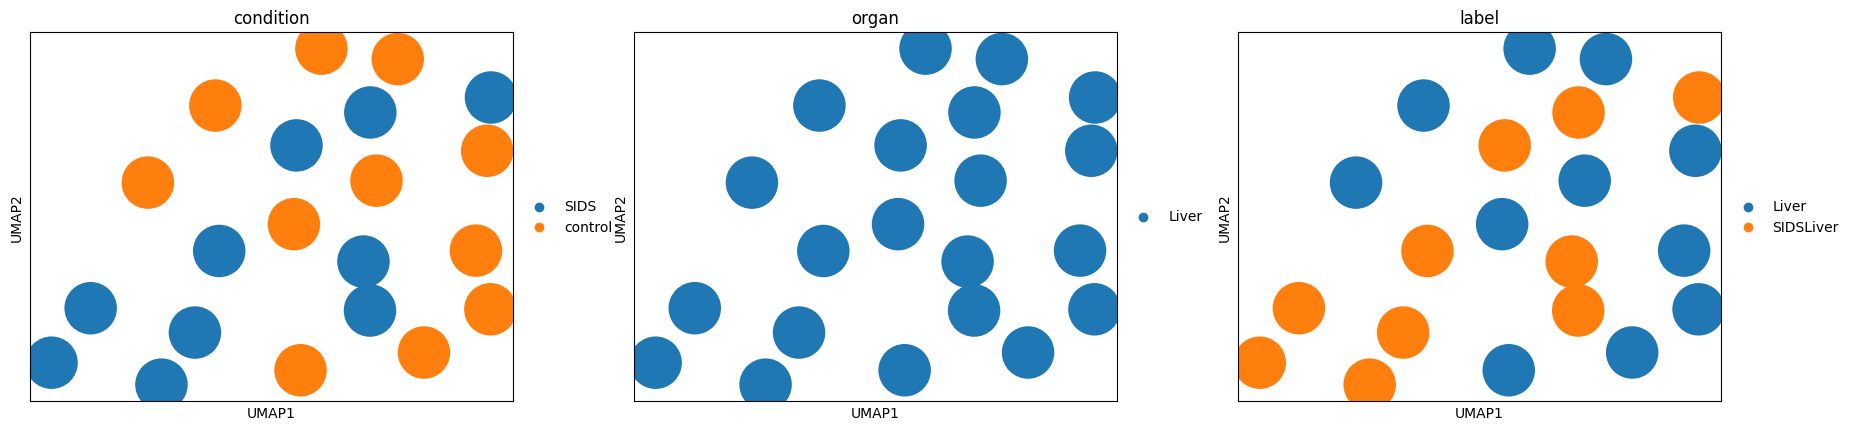

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


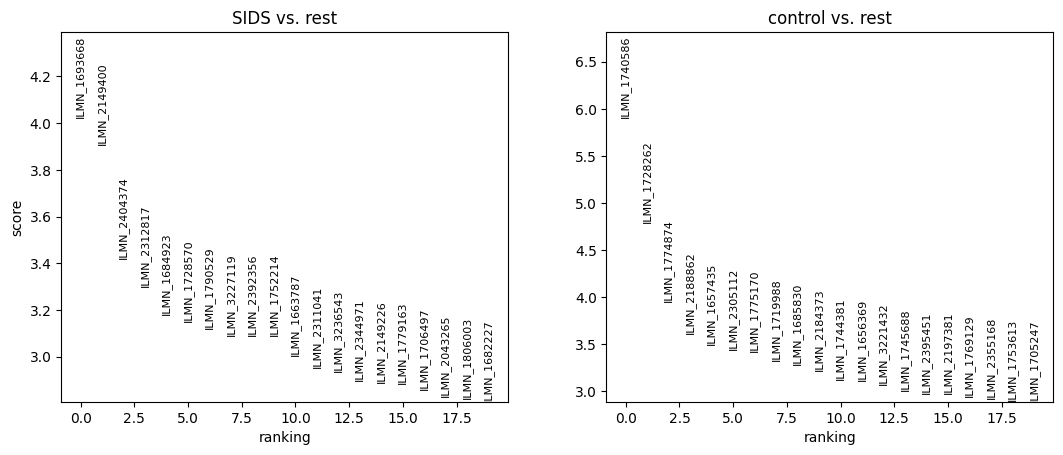

In [ ]:



import scanpy as sc
import numpy as np
import pandas as pd

# Assuming 'adata' is already loaded

# 1. Clean data: Convert to float, remove NaNs, replace infs
adata.X = adata.X.astype(np.float64)
adata.X[np.isnan(adata.X)] = 0  # Replace NaNs with 0
finite_max = np.max(adata.X[np.isfinite(adata.X)])
adata.X[np.isinf(adata.X)] = finite_max  # Replace infs with max real value
adata.X = np.clip(adata.X, a_min=None, a_max=1e4)  # Prevent extreme overflow

# 2. Add sample names and group labels

simple_title_map = {
    "GSM1728971": "SIDSBrain",
    "GSM1728972": "SIDSBrain",
    "GSM1728973" :"SIDSBrain",
    "GSM1728974"  :"SIDSBrain",
    "GSM1728975":"SIDSBrain",
    "GSM1728976": "SIDSBrain",
    "GSM1728977": "SIDSBrain",
    "GSM1728978":"SIDSBrain",
    "GSM1728979":"SIDSBrain",
    "GSM1728980":"SIDSBrain",
    "GSM1728981":"Brain",
    "GSM1728982":"Brain",
    "GSM1728983":"Brain",
    "GSM1728984":"Brain",
    "GSM1728985":"Brain",
    "GSM1728986":"Brain",
    "GSM1728987":"Brain",
    "GSM1728988":"Brain",
    "GSM1728989":"Brain",
    "GSM1728990":"Brain",
    "GSM1728991":"Brain",
    "GSM1728992":"SIDSLiver",
    "GSM1728993":"SIDSLiver",
    "GSM1728994":"SIDSLiver",
    "GSM1728995":"SIDSLiver",
    "GSM1728996":"SIDSLiver",
    "GSM1728997":"SIDSLiver",
    "GSM1728998":"SIDSLiver",
    "GSM1728999":"SIDSLiver",
    "GSM1729000":"SIDSLiver",
    "GSM1729001":"SIDSLiver",
    "GSM1729002":"Liver",
    "GSM1729003":"Liver",
    "GSM1729004":"Liver",
    "GSM1729005":"Liver",
    "GSM1729006":"Liver",
    "GSM1729007":"Liver",
    "GSM1729008":"Liver",
    "GSM1729009":"Liver",
    "GSM1729010":"Liver",
    "GSM1729011":"Liver",
    "GSM1729012":"Liver",
    "GSM1729013":"SIDSHeart",
    "GSM1729014":"SIDSHeart",
    "GSM1729015":"SIDSHeart",
    "GSM1729016":"SIDSHeart",
    "GSM1729017":"SIDSHeart",
    "GSM1729018":"SIDSHeart",
    "GSM1729019":"SIDSHeart",
    "GSM1729020":"Heart",
    "GSM1729021":"Heart",
    "GSM1729022":"Heart",
    "GSM1729023":"Heart",
    "GSM1729024":"Heart",
    "GSM1729025":"Heart",
    "GSM1729026":"Heart",
    "GSM1729027":"Heart",
    "GSM1729028":"Heart",
    }
# Add combined label as-is:
adata.obs['label'] = [simple_title_map.get(s, "unknown") for s in adata.obs['sample']]

# Filter liver samples:
adata_liver = adata[adata.obs['label'].str.contains("Liver")].copy()

# Optional: If you want to recover 'condition' and 'organ' for plotting or grouping:
adata_liver.obs['condition'] = adata_liver.obs['label'].apply(lambda x: "SIDS" if x.startswith("SIDS") else "control")
adata_liver.obs['organ'] = adata_liver.obs['label'].apply(lambda x: x.replace("SIDS", "") if x.startswith("SIDS") else x)
# Show the first few rows of the metadata
adata_liver.obs[['label', 'condition', 'organ']].head()

# Summary of how many samples per group
print(adata_liver.obs['condition'].value_counts())
print(adata_liver.obs['organ'].value_counts())

# Run standard Scanpy pipeline if not yet run
sc.tl.pca(adata_liver)
sc.pp.neighbors(adata_liver)
sc.tl.umap(adata_liver)

# Plot UMAP
sc.pl.umap(adata_liver, color=['condition', 'organ', 'label'])
# Ensure 'condition' exists in the liver subset
if 'condition' in adata_liver.obs.columns:
    sc.tl.rank_genes_groups(
        adata_liver,
        groupby='condition',
        method='t-test',
        use_raw=False  # Assuming you're working with processed data
    )

    # Plot top 20 genes for each condition
    sc.pl.rank_genes_groups(adata_liver, n_genes=20, sharey=False)
else:
    print("No 'condition' column found in adata_liver.obs.")

# Convert DE results to a Pandas DataFrame
de_results = sc.get.rank_genes_groups_df(adata_liver, group=None)

# Save to CSV
de_results.to_csv("/content/liver_SIDS_vs_control_DE_results.csv", index=False)


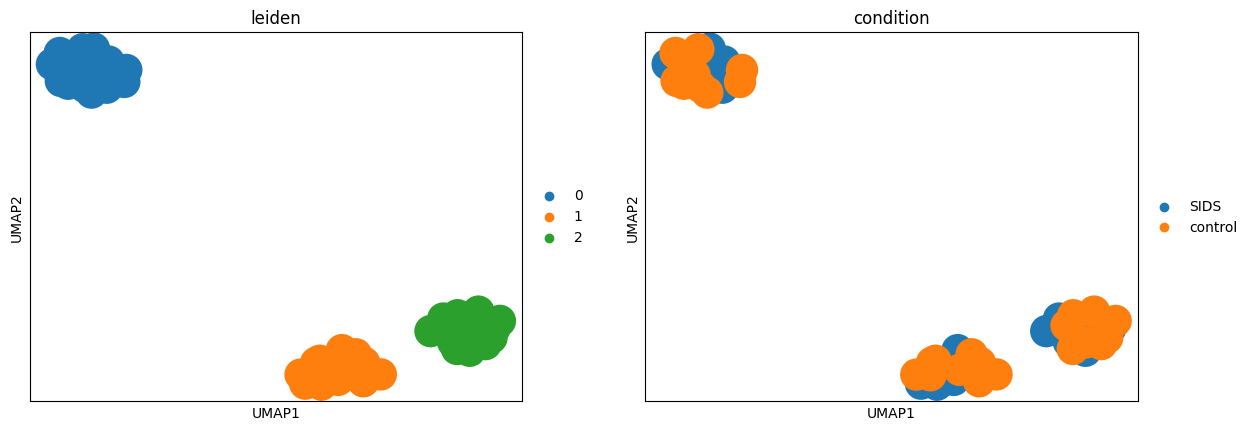

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


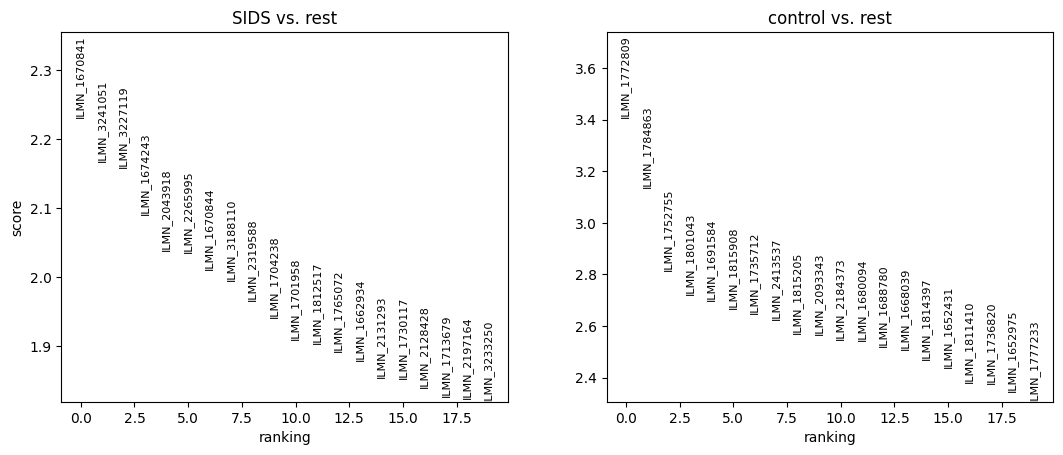

In [ ]:

import scanpy as sc
import numpy as np
import pandas as pd

# Assuming 'adata' is already loaded

# 1. Clean data: Convert to float, remove NaNs, replace infs
adata.X = adata.X.astype(np.float64)
adata.X[np.isnan(adata.X)] = 0  # Replace NaNs with 0
finite_max = np.max(adata.X[np.isfinite(adata.X)])
adata.X[np.isinf(adata.X)] = finite_max  # Replace infs with max real value
adata.X = np.clip(adata.X, a_min=None, a_max=1e4)  # Prevent extreme overflow

# 2. Add sample names and group labels
# 11. Sample names and condition labels
sample_names = ["GSM1728971","GSM1728972","GSM1728973", "GSM1728974",
                "GSM1728975", "GSM1728976","GSM1728977", "GSM1728978","GSM1728979",
                "GSM1728980","GSM1728981","GSM1728982",
                "GSM1728983","GSM1728984","GSM1728985","GSM1728986",
                "GSM1728988", "GSM1728989", "GSM1728990", "GSM1728991","GSM1728992","GSM1728993",
                "GSM1728994","GSM1728995","GSM1728996",
                "GSM1728997","GSM1728998","GSM1728999","GSM1729000","GSM1729001",
                "GSM1729002","GSM1729003",
                "GSM1729004", "GSM1729005", "GSM1729006","GSM1729007",
                "GSM1729008", "GSM1729009", "GSM1729010", "GSM1729011", "GSM1729012",
                "GSM1729013", "GSM1729014", "GSM1729015", "GSM1729017",
                "GSM1729018", "GSM1729019",
                "GSM1729020","GSM1729021", "GSM1729022",
                "GSM1729023", "GSM1729024","GSM1729026", "GSM1729027",
                "GSM1729028"]
 # Your full sample_names list here
groups = ['SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS',
          'SIDS','SIDS','control','control','control','control','control','control',
          'control','control','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','SIDS',
          'SIDS','SIDS','control','control','control','control','control',
          'control','control','control','control','control','SIDS',
          'SIDS','SIDS','SIDS','SIDS','SIDS','SIDS','control',
          'control','control','control','control','control',
          'control',"control","control", "control"]
import scanpy as sc       # Your full groups list here
adata.obs['sample'] = sample_names
adata.obs['condition'] = groups

# 3. Filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# 4. Calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# 5. Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 6. Identify highly variable genes
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)
adata = adata[:, adata.var.highly_variable].copy()

# 7. Scale data
sc.pp.scale(adata, max_value=10)

# 8. PCA
sc.tl.pca(adata, svd_solver='arpack')

# 9. Compute neighbors and UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# 10. Clustering (requires igraph installed)
sc.tl.leiden(adata, resolution=0.5)

# 11. Visualize
sc.pl.umap(adata, color=['leiden', 'condition'])

# 12. Differential expression (if 'condition' exists)
if 'condition' in adata.obs.columns:
    sc.tl.rank_genes_groups(adata, groupby='condition', method='t-test')
    sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
else:
    print("No 'condition' column found in adata.obs for differential expression.")



In [ ]:
import pandas as pd

# Run DE analysis if not already done
sc.tl.rank_genes_groups(adata, groupby='condition', method='t-test')

# Extract the results from the DE analysis
result = adata.uns['rank_genes_groups']

# Convert to a pandas DataFrame (showing top 1000 genes)
groups = result['names'].dtype.names  # typically: ['SIDS', 'control'] or vice versa

# Initialize an empty list to hold DataFrames
dfs = []

for group in groups:
    df = pd.DataFrame({
        'gene': result['names'][group],
        'logfoldchange': result['logfoldchanges'][group],
        'pval': result['pvals'][group],
        'pval_adj': result['pvals_adj'][group],
        'score': result['scores'][group]
    })
    df['group'] = group
    dfs.append(df)

# Concatenate all groups into one DataFrame
de_df = pd.concat(dfs)

# Sort by adjusted p-value and take top 1000
top_de_genes = de_df.sort_values('pval_adj').head(10000)

# Save to CSV
top_de_genes.to_csv("top_1000_DE_genes.csv", index=False)

print("✅ Top 1000 DE genes saved to 'top_1000_DE_genes.csv'")


✅ Top 1000 DE genes saved to 'top_1000_DE_genes.csv'


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [ ]:

sample_group_map = dict(zip(sample_names, groups))

# Read CSV files, extract expression data
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

expr_list = []
sample_list = []

for file in csv_files:
    path = os.path.join(folder_path, file)
    df = pd.read_csv(path)

    if 'Reporter Identifier' not in df.columns or 'VALUE' not in df.columns:
        print(f"Skipping {file}: missing required columns")
        continue

    expr = df.set_index('Reporter Identifier')['VALUE']
    sample_name = os.path.splitext(file)[0].split("_")[0]  # extract sample ID to match mapping keys

    expr.name = sample_name
    expr_list.append(expr)
    sample_list.append(sample_name)

NameError: name 'sample_names' is not defined

In [ ]:
1+2

3

In [ ]:
ajdajd adsakjdsa k

SyntaxError: invalid syntax (<ipython-input-68-60132cef46ba>, line 1)